In [359]:
from ultralytics import YOLO
yolo  = YOLO("yolov8n.pt")

In [360]:
from transformers import GLPNImageProcessor, GLPNForDepthEstimation
import torch
import numpy as np
import cv2

from PIL import Image
import requests
import matplotlib.pyplot as plt

In [361]:
# Load GLPN (Global-Local Path Network) depth model
processor = GLPNImageProcessor.from_pretrained("vinvino02/glpn-nyu")
depth_model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")

# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
depth_model.to(device)

GLPNForDepthEstimation(
  (glpn): GLPNModel(
    (encoder): GLPNEncoder(
      (patch_embeddings): ModuleList(
        (0): GLPNOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): GLPNOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): GLPNOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): GLPNOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
      )
      (block): ModuleList(

In [362]:

# # Capture image from the PC camera
# cap = cv2.VideoCapture(0)  # 0 for the default camera

# if not cap.isOpened():
#     raise IOError("Cannot open webcam")

# ret, frame = cap.read()
# cap.release()

# if not ret:
#     raise IOError("Failed to capture image")

# # Convert the frame to PIL Image
# image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# # Original image for further processing
# or_img = image
# orignal_image_size = image.size

# # Resize image for processing
# image = image.resize((640, 480), Image.LANCZOS)
# image_np = np.array(image)  # Convert to NumPy array for YOLO
# or_np = np.array(or_img)  # Original NumPy array

# # Prepare image for depth model
# inputs = processor(images=image, return_tensors="pt").to(device)

# # Get predicted depth
# with torch.no_grad():
#     outputs = depth_model(**inputs)
#     predicted_depth = outputs.predicted_depth

# # Interpolate to original image size
# depth_map = torch.nn.functional.interpolate(
#     predicted_depth.unsqueeze(1),
#     size=image.size[::-1],
#     mode="bicubic",
#     align_corners=False,
# ).squeeze().cpu().numpy()


In [363]:
import cv2
import numpy as np
import torch
from PIL import Image

# Initialize camera
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open webcam")

print("Press Enter to capture the image...")
while True:
    ret, frame = cap.read()
    cv2.imshow("Live Feed", frame)
    key = cv2.waitKey(1) & 0xFF
    if key == 13:  # 13 is the Enter key
        break

cap.release()
cv2.destroyAllWindows()

if not ret:
    raise IOError("Failed to capture image")

# Convert the frame to PIL Image
image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Original image for further processing
or_img = image
original_image_size = image.size

# Resize image for processing
image = image.resize((640, 480), Image.LANCZOS)
image_np = np.array(image)  # Convert to NumPy array for YOLO
or_np = np.array(or_img)  # Original NumPy array

# Prepare image for depth model
inputs = processor(images=image, return_tensors="pt").to(device)

# Get predicted depth
with torch.no_grad():
    outputs = depth_model(**inputs)
    predicted_depth = outputs.predicted_depth

# Interpolate to original image size
depth_map = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
).squeeze().cpu().numpy()

print("Image captured and processed.")


Press Enter to capture the image...
Image captured and processed.


In [364]:
# Load YOLOv8n model
yolo_model = YOLO("yolov8n.pt")

# Run object detection
results = yolo_model(image_np)


0: 480x640 1 person, 76.8ms
Speed: 2.8ms preprocess, 76.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


In [365]:
IMAGE_WIDTH_PIXELS = 1280  # Adjust based on actual resolution
IMAGE_HEIGHT_PIXELS = 720  # Adjust based on actual resolution

In [366]:
orig_w, orig_h = original_image_size  # Original image size
resized_w, resized_h = image.size  # Resized image used for depth estimation

# Compute scaling factors
scale_x = orig_w / resized_w
scale_y = orig_h / resized_h

In [367]:
import numpy as np

heights = []  # Initialize list for storing object heights
widths = []   # Initialize list for storing object widths

# Original and resized image sizes
orig_w, orig_h = original_image_size  
resized_w, resized_h = image.size  

# Camera parameters
IMAGE_WIDTH_PIXELS = 1280  
IMAGE_HEIGHT_PIXELS = 720  
FOCAL_LENGTH_MM = 3.5  
SENSOR_WIDTH_MM = 3.6  
SENSOR_HEIGHT_MM = 2.7  

# Convert focal length to pixels
FOCAL_LENGTH_PIXELS = (FOCAL_LENGTH_MM * IMAGE_WIDTH_PIXELS) / SENSOR_WIDTH_MM

# Compute Horizontal & Vertical Field of View (FOV)
HFOV_rad = 2 * np.arctan((SENSOR_WIDTH_MM / 2) / FOCAL_LENGTH_MM)
VFOV_rad = 2 * np.arctan((SENSOR_HEIGHT_MM / 2) / FOCAL_LENGTH_MM)

HFOV_deg = np.degrees(HFOV_rad)
VFOV_deg = np.degrees(VFOV_rad)

# YOLO Class Labels
CLASS_NAMES = {
    0: "Person",
    39: "Bottle",
    60: "Cup",
    75: "Chair",
    9: 'traffic light',
    10: 'fire hydrant', 
    11: 'stop sign', 
    # 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch',
    67: "cell phone", 
    68: 'microwave', 
    69: 'oven'
}

# Extract bounding boxes and labels
for result in results:
    boxes = result.boxes.xyxy.cpu().numpy()  
    labels = result.boxes.cls.cpu().numpy()  

# Iterate over detected objects
object_depths = []
depth_correction_factor = 0.61 / 1.29  

for i, box in enumerate(boxes):
    x_min, y_min, x_max, y_max = map(int, box)

    # Scale bounding box dimensions to original image size
    scale_x = orig_w / resized_w
    scale_y = orig_h / resized_h

    scaled_x_min = int(x_min * scale_x)
    scaled_y_min = int(y_min * scale_y)
    scaled_x_max = int(x_max * scale_x)
    scaled_y_max = int(y_max * scale_y)

    # Compute bounding box width & height in pixels
    scaled_pixel_width = scaled_x_max - scaled_x_min
    scaled_pixel_height = scaled_y_max - scaled_y_min

    # Extract depth values within bounding box (from resized depth map)
    object_depth = depth_map[y_min:y_max, x_min:x_max]

    # Filter out extreme depth values (outliers)
    if object_depth.size > 0:
        object_depth = object_depth[(object_depth > 0) & (object_depth < 10)]
        median_depth = np.median(object_depth) if object_depth.size > 0 else 0
    else:
        median_depth = 0  

    # Apply depth correction factor
    median_depth *= depth_correction_factor
    object_depths.append(median_depth)

    # Compute real-world width and height
    real_width = 2 * median_depth * np.tan(np.radians(HFOV_deg / 2)) * (scaled_pixel_width / orig_w)
    real_height = 2 * median_depth * np.tan(np.radians(VFOV_deg / 2)) * (scaled_pixel_height / orig_h)

    # Store values in lists ✅
    widths.append(real_width)
    heights.append(real_height)
    class_names = []
    # Get class name
    class_name = CLASS_NAMES.get(int(labels[i]), f"Class {labels[i]}")
    class_names.append(class_name)
    # Print results
    print(f"Object {i} ({class_name}):")
    print(f"   Estimated Depth  = {median_depth:.2f} meters")
    print(f"   Estimated Width  = {real_width:.2f} meters")
    print(f"   Estimated Height = {real_height:.2f} meters")
    print(" ")


Object 0 (Person):
   Estimated Depth  = 0.89 meters
   Estimated Width  = 0.46 meters
   Estimated Height = 0.68 meters
 


In [368]:
result

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant',

In [369]:
object_depths, heights, widths

([np.float32(0.8923558)],
 [np.float64(0.6769156137534551)],
 [np.float64(0.4589258398328509)])

In [370]:
class_names

['Person']

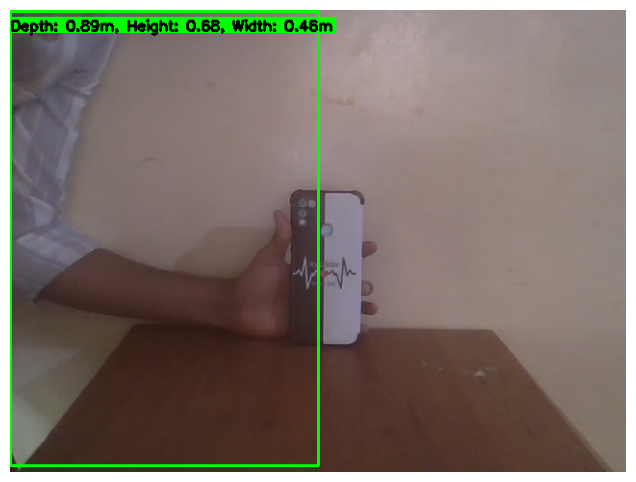

In [371]:
import cv2
import matplotlib.pyplot as plt

# Convert image to BGR for OpenCV processing
image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)  

for i, box in enumerate(boxes):
    x_min, y_min, x_max, y_max = map(int, box)

    # Ensure valid indices to prevent IndexError
    if i >= len(object_depths) or i >= len(heights) or i >= len(widths):
        print(f"Warning: Skipping object {i}, insufficient data available.")
        continue  

    # Calculate text position
    text = f"Depth: {object_depths[i]:.2f}m, Height: {heights[i]:.2f}, Width: {widths[i]:.2f}m"
    text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
    text_x, text_y = x_min, y_min - 10  # Default position (above bbox)

    # If text goes above image, place it inside the box
    if text_y - text_size[1] < 0:
        text_y = y_min + 20  # Move inside bounding box

    # Draw bounding box
    cv2.rectangle(image_np, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    # Draw text background (for better visibility)
    cv2.rectangle(
        image_np, 
        (text_x, text_y - text_size[1] - 2), 
        (text_x + text_size[0] + 2, text_y + 2), 
        (0, 255, 0), 
        -1
    )

    # Draw text
    cv2.putText(
        image_np,
        text,
        (text_x, text_y),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 0),  # Black text for contrast
        2
    )

# Convert image back to RGB for displaying in matplotlib
image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

# Show the image using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(image_np)
plt.axis("off")
plt.show()
